In [2]:
import numpy as np
import os, re
import json
import h5py as h5
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import time
import matplotlib.pyplot as plt

import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions

## Load data

Load some data from the [CaloGAN dataset](https://data.mendeley.com/datasets/pvn3xc3wy5/1). Here we use the pion dataset since the skin depth is high and not all the energy is deposited in the calorimeter layers, and hence the conditional probability distribution is more interesting.

In [3]:
def DataLoader(file_name,nevts):
    '''
    Inputs:
    - name of the file to load
    - number of events to use
    Outputs:
    - Generated particle energy (value to condition the flow) (nevts,1)
    - Energy deposition in each layer (nevts,3)
    - Normalized energy deposition per voxel (nevts,504)
    '''
    with h5.File(file_name,"r") as h5f:
        e = h5f['energy'][:int(nevts)].astype(np.float32)
        layer0= h5f['layer_0'][:int(nevts)].astype(np.float32)
        layer1= h5f['layer_1'][:int(nevts)].astype(np.float32)
        layer2= h5f['layer_2'][:int(nevts)].astype(np.float32)

    def preprocessing(data):
        ''' 
        Inputs: Energy depositions in a layer
        Outputs: Total energy of the layer and normalized energy deposition
        '''
        x = data.shape[1]
        y = data.shape[2]
        data_flat = np.reshape(data,[-1,x*y])
        #uncomment below to add noise like caloflows does
        #data_flat +=np.random.uniform(0,1e-3,size=data_flat.shape)
        energy_layer = np.sum(data_flat,-1).reshape(-1,1)
        #Some particle showers have no energy deposition at the last layer
        data_flat = np.ma.divide(data_flat,energy_layer).filled(0)
        return energy_layer,data_flat


    flat_energy , flat_shower = preprocessing(np.nan_to_num(layer0))    
    for il, layer in enumerate([layer1,layer2]):
        energy ,shower = preprocessing(np.nan_to_num(layer))
        flat_energy = np.concatenate((flat_energy,energy),-1)
        flat_shower = np.concatenate((flat_shower,shower),-1)
        
    return e,flat_energy,flat_shower


NSAMPLES = 100000 # number of data points to load

file_path = '/global/home/users/haoxing_du/ToyFlow/piplus.hdf5'
energy, energy_layer, energy_voxel = DataLoader(file_path, NSAMPLES)
print(energy.shape, energy_layer.shape, energy_voxel.shape)

(100000, 1) (100000, 3) (100000, 504)


Visualize the dataset in various ways.

(array([10023., 10027.,  9974., 10026., 10064.,  9886.,  9903., 10030.,
        10114.,  9953.]),
 array([ 1.0007036, 10.9005785, 20.800453 , 30.700327 , 40.6002   ,
        50.500076 , 60.399952 , 70.29983  , 80.1997   , 90.09958  ,
        99.99945  ], dtype=float32),
 <BarContainer object of 10 artists>)

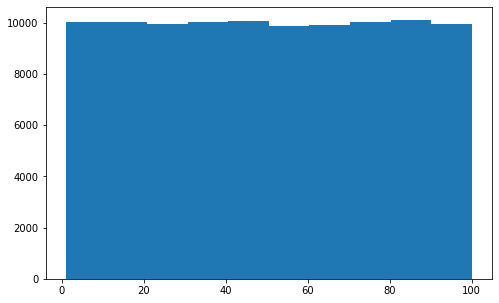

In [3]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,5)

# histogram of energies
plt.hist(energy)

In [4]:
layer0 = [x[0] for x in energy_layer]
layer0 = np.array(layer0)

layer1 = [x[1] for x in energy_layer]
layer1 = np.array(layer1)

layer2 = [x[2] for x in energy_layer]
layer2 = np.array(layer2)

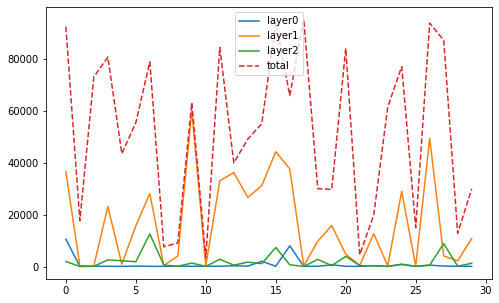

In [5]:
# Plot the energy in each layer for the first 30 entries
plt.plot(layer0[3000:3030],label='layer0')
plt.plot(layer1[3000:3030],label='layer1')
plt.plot(layer2[3000:3030],label='layer2')
plt.plot(energy[3000:3030]*1000,label='total',linestyle='dashed')
plt.legend()

In [159]:
# Let's look at a random data point

i = np.random.randint(1000)

print(f"True particle energy: {energy[i][0]*1000} MeV")
print(f"Layer 0 energy: {layer0[i]} MeV")
print(f"Layer 1 energy: {layer1[i]} MeV")
print(f"Layer 2 energy: {layer2[i]} MeV")
print(f"Difference (true - total): {energy[i][0]*1000-layer0[i]-layer1[i]-layer2[i]} MeV")

True particle energy: 77999.13787841797 MeV
Layer 0 energy: 120.82713317871094 MeV
Layer 1 energy: 8141.8544921875 MeV
Layer 2 energy: 3649.426025390625 MeV
Difference (true - total): 66087.03022766113 MeV


In [ ]:
max(layer0)

## Train a FFJORD

to learn the conditional probability distribution $p(E_0, E_1, E_2 | E_\text{tot})$.

In [5]:
class MLP_ODE(keras.Model):
    """Multi-layer NN ode_fn."""
    def __init__(self, num_hidden, num_layers, num_output,num_cond=2,name='mlp_ode'):
        super(MLP_ODE, self).__init__()
        self._num_hidden = num_hidden
        self._num_output = num_output
        self._num_layers = num_layers
        self._num_cond = num_cond
        self._modules = []
        
        #Fully connected layers with tanh activation and linear output
        self._modules.append(Input(shape=(1+self._num_output+self._num_cond))) #time is part of the inputs
        for _ in range(self._num_layers - 1):
            self._modules.append(layers.Dense(self._num_hidden,activation='tanh'))
            
        self._modules.append(layers.Dense(self._num_output,activation=None))
        self._model = keras.Sequential(self._modules)

        if self._num_cond > 1:
            #In more dimensiona, is useful to feed the conditional distributions after passing through an independent network model
            self._cond_model = keras.Sequential(
                [
                    Input(shape=(self._num_cond)),
                    layers.Dense(self._num_hidden,activation='relu'),
                    layers.Dense(self._num_cond,activation=None),
                ])
        
    @tf.function
    def call(self, t, data,conditional_input=None):
        if self._num_cond==1:
            #No network for a single feature
            cond_transform=tf.cast(conditional_input,dtype=tf.float32)
        else:
            cond_transform = self._cond_model(conditional_input)
            
        t = t*tf.ones([data.shape[0],1])
        inputs = tf.concat([t, data,cond_transform], -1)
        return self._model(inputs)

def make_bijector_kwargs(bijector, name_to_kwargs):
    #Hack to pass the conditional information through all the bijector layers
    if hasattr(bijector, 'bijectors'):
        return {b.name: make_bijector_kwargs(b, name_to_kwargs) for b in bijector.bijectors}
    else:
        for name_regex, kwargs in name_to_kwargs.items():
            if re.match(name_regex, bijector.name):
                return kwargs
    return {}

def save_model(model,name="ffjord",checkpoint_dir = '../checkpoints'):
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    model.save_weights('{}/{}'.format(checkpoint_dir,name,save_format='tf'))

def load_model(model,name="ffjord",checkpoint_dir = '../checkpoints'):
    model.load_weights('{}/{}'.format(checkpoint_dir,name,save_format='tf')).expect_partial()
    
        
class FFJORD(keras.Model):
    def __init__(self, stacked_mlps, batch_size,num_output,trace_type='hutchinson',name='FFJORD'):
        super(FFJORD, self).__init__()
        self._num_output=num_output
        self._batch_size = batch_size 
        ode_solve_fn = tfp.math.ode.DormandPrince(atol=1e-5).solve
        #Gaussian noise to trace solver
        if trace_type=='hutchinson':
            trace_augmentation_fn = tfb.ffjord.trace_jacobian_hutchinson
        elif trace_type == 'exact':
            trace_augmentation_fn = tfb.ffjord.trace_jacobian_exact
        else:
            raise Exception("Invalid trace estimator")
        
        
        bijectors = []
        for imlp,mlp in enumerate(stacked_mlps):
            ffjord = tfb.FFJORD(
                state_time_derivative_fn=mlp,
                ode_solve_fn=ode_solve_fn,
                trace_augmentation_fn=trace_augmentation_fn,
                name='bijector{}'.format(imlp) #Bijectors need to be names to receive conditional inputs
            )
            bijectors.append(ffjord)

        #Reverse the bijector order
        self.chain = tfb.Chain(list(reversed(bijectors)))

        self.loss_tracker = keras.metrics.Mean(name="loss")
        #Determien the base distribution
        self.base_distribution = tfp.distributions.MultivariateNormalDiag(
            loc=self._num_output*[0.0], scale_diag=self._num_output*[1.0]
        )
        
        self.flow=self.Transform()
        self._variables = self.flow.variables
        
    @property
    def metrics(self):
        """List of the model's metrics.
        We make sure the loss tracker is listed as part of `model.metrics`
        so that `fit()` and `evaluate()` are able to `reset()` the loss tracker
        at the start of each epoch and at the start of an `evaluate()` call.
        """
        return [self.loss_tracker]
    
    @tf.function
    def call(self, inputs, conditional_input=None):
        kwargs = make_bijector_kwargs(self.flow.bijector,{'bijector.': {'conditional_input':conditional_input }})
        return self.flow.bijector.forward(inputs,**kwargs)
        
            
    def Transform(self):        
        return tfd.TransformedDistribution(distribution=self.base_distribution, bijector=self.chain)

    
    @tf.function
    def log_loss(self,_x,_c):
        loss = -tf.reduce_mean(self.flow.log_prob(
            _x,
            bijector_kwargs=make_bijector_kwargs(
                self.flow.bijector, {'bijector.': {'conditional_input': _c}})                                      
        ))
        
        return loss
    
    @tf.function
    def conditional_prob(self,_x,_c):
        prob = self.flow.prob(
            _x,
            bijector_kwargs=make_bijector_kwargs(
                self.flow.bijector, {'bijector.': {'conditional_input': _c}})                                      
        )
        
        return prob
    
    @tf.function
    def conditional_log_prob(self,_x,_c):
        return self.flow.log_prob(
            _x,
            bijector_kwargs=make_bijector_kwargs(
                self.flow.bijector, {'bijector.': {'conditional_input': _c}})                                      
        )
    
    
    @tf.function()
    def train_step(self, values):
        #Full shape needs to be given when using tf.dataset
        data = values[:self._batch_size,:self._num_output]
        cond = values[:self._batch_size,self._num_output:]
        data.set_shape((self._batch_size,self._num_output))
        cond.set_shape((self._batch_size,cond.shape[1]))

        with tf.GradientTape() as tape:
            loss = self.log_loss(data,cond)
            
        g = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(g, self.trainable_variables))
        self.loss_tracker.update_state(loss)

        return {"loss": self.loss_tracker.result()}
    
    @tf.function
    def test_step(self, values):
        data = values[:self._batch_size,:self._num_output]
        cond = values[:self._batch_size,self._num_output:]
        data.set_shape((self._batch_size,self._num_output))
        cond.set_shape((self._batch_size,cond.shape[1]))
        
        loss = self.log_loss(data,cond)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

Since energies are positive and it is difficult for the model to learn hard boundaries like this, we take the logarithm of the energies (in MeV) divided by 10000.

In [6]:
all_energies = np.concatenate([energy_layer, energy*1000],-1)
all_energies += 1e-10 # in case there are 0s and taking log of 0 is an issue
energies_log = np.log10(all_energies/10000)
energies_log

array([[-2.2511692 , -1.5900394 , -1.5778993 ,  0.26130608],
       [-2.1437201 , -1.6087798 , -2.5927675 ,  0.3239099 ],
       [-2.2243292 , -1.2161549 , -0.75706685,  0.8912002 ],
       ...,
       [-2.2814069 , -1.5837944 , -2.6668835 , -0.2972053 ],
       [-0.57255614,  0.06363591, -1.4209859 ,  0.58726406],
       [-2.174737  , -0.02242722, -1.6710408 ,  0.9420588 ]],
      dtype=float32)

In [7]:
LR = 4e-5
NUM_EPOCHS = 100
STACKED_FFJORDS = 5 #Number of stacked transformations
NUM_LAYERS = 3 #Hiddden layers per bijector
NUM_OUTPUT = 3 #Output dimension
NUM_HIDDEN = 20*NUM_OUTPUT #Hidden layer node size
NUM_COND = 1 #Number of conditional dimensions

BATCH_SIZE = 200

#Stack of bijectors 
stacked_mlps = []
for _ in range(STACKED_FFJORDS):
    mlp_model = MLP_ODE(NUM_HIDDEN, NUM_LAYERS, NUM_OUTPUT, NUM_COND)
    stacked_mlps.append(mlp_model)

callbacks=[
        EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=1e-6, verbose=1, cooldown=0)
]
    
#Create the model
model = FFJORD(stacked_mlps,BATCH_SIZE,NUM_OUTPUT,trace_type='hutchinson')
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LR))
#model.compile(optimizer=keras.optimizers.SGD(learning_rate=LR))

trainableParams = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
nonTrainableParams = np.sum([np.prod(v.get_shape()) for v in model.non_trainable_weights])
totalParams = trainableParams + nonTrainableParams
print(f"Number of trainable params: {trainableParams}")
print(f"Number of nontrainable params: {nonTrainableParams}")
print(f"Number of total params: {totalParams}")

history = model.fit(
    energies_log,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=1,
    validation_split=0.1,
    callbacks=callbacks,
)

2022-06-01 19:59:19.595261: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/global/home/users/haoxing_du/anaconda3/envs/new_env/lib/:/global/home/users/haoxing_du/anaconda3/envs/tf2/lib/
2022-06-01 19:59:19.595309: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-06-01 19:59:19.595850: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To 

Number of trainable params: 21015
Number of nontrainable params: 2.0
Number of total params: 21017.0
Epoch 1/100
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))
450/450 [==============================] - 147s 184ms/step - loss: 3.1625 - val_loss: 2.5780 - lr: 4.0000e-05
Epoch 2/100
450/450 [==============================] - 83s 185ms/step - loss: 2.3429 - val_loss: 2.1084 - lr: 4.0000e-05
Epoch 3/100
450/450 [==============================] - 97s 215ms/step - loss: 1.9104 - val_loss: 1.7744 - lr: 4.0000e-05
Epoch 4/100
450/450 [==============================] - 100s 221ms/step - loss: 1.6346 - val_loss: 1.5695 - lr: 4.0000e-05
Epoch 5/100
450/450 [==============================] - 105s 233ms/step - loss: 1.4733 - val_loss: 1.4727 - lr: 4.0000e-05
Epoch 6/100
450/450 [========================

In [ ]:
history.history

In [162]:
min(history.history['val_loss'])

0.39970606565475464

Take some samples from the model and see what it has learned.

In [163]:
NSAMPLES = 100000

energy_scaled = energies_log[:,-1].reshape((NSAMPLES,1))

#Sample the learned distribution
samples_with_energy = model.flow.sample(
    NSAMPLES,
    bijector_kwargs=make_bijector_kwargs(
        model.flow.bijector, {'bijector.': {'conditional_input': energy_scaled}})
)

In [164]:
samples_scaled = np.concatenate([samples_with_energy, energy_scaled],-1)
#transformed_scaled_back = scaler.inverse_transform(transformed_scaled)
samples_expd = 10**samples_scaled * 10000
layer0_sampled = samples_expd[:,0]
layer1_sampled = samples_expd[:,1]
layer2_sampled = samples_expd[:,2]

In [64]:
def plot_hist_3_layers(layer0, layer1, layer2, layer0_sampled, layer1_sampled, layer2_sampled):
    fig = plt.figure(figsize=(18, 4))
    plt.subplot(131)    
    plt.hist(layer0, bins=np.linspace(0,25000,21), label='actual')
    plt.hist(layer0_sampled, bins=np.linspace(0,25000,21), fc=(0,0,0,0), edgecolor='orange', linewidth=1.2, label='learned')
    plt.xlabel('layer 0 energy (MeV)')
    plt.legend()
    plt.subplot(132)    
    plt.hist(layer1, bins=np.linspace(0,90000,21), label='actual')
    plt.hist(layer1_sampled, bins=np.linspace(0,90000,21), fc=(0,0,0,0), edgecolor='orange', linewidth=1.2, label='learned')
    plt.xlabel('layer 1 energy (MeV)')
    plt.legend()
    plt.subplot(133)    
    plt.hist(layer2, bins=np.linspace(0,29000,21), label='actual')
    plt.hist(layer2_sampled, bins=np.linspace(0,29000,21), fc=(0,0,0,0), edgecolor='orange', linewidth=1.2, label='learned')
    plt.xlabel('layer 2 energy (MeV)')
    plt.legend()

In [71]:
def plot_scat_layers_v_tot(energy, layer0, layer1, layer2, \
                           layer0_sampled, layer1_sampled, layer2_sampled, \
                           max0, max1, max2):
    fig = plt.figure(figsize=(16, 8))
    plt.subplot(231)
    plt.scatter(energy, layer0, label='actual')
    plt.legend()
    plt.subplot(232)
    plt.scatter(energy, layer1, label='actual')
    plt.subplot(233)
    plt.scatter(energy, layer2, label='actual')
    plt.subplot(234)
    plt.scatter(energy, layer0_sampled, color='orange', label='learned')
    plt.ylim(0,max0)
    plt.legend()
    plt.subplot(235)
    plt.scatter(energy, layer1_sampled, color='orange', label='learned')
    plt.ylim(0,max1)
    plt.subplot(236)
    plt.scatter(energy, layer2_sampled, color='orange', label='learned')
    plt.ylim(0,max2)
    fig.supxlabel('total energy (GeV)')
    fig.supylabel('energy in each layer (MeV)')

In [1]:
def plot_sum_v_tot(energy, layer0, layer1, layer2, layer0_sampled, layer1_sampled, layer2_sampled):
    fig = plt.figure(figsize=(12, 5))
    plt.subplot(121)
    plt.scatter(energy*1000, layer0+layer1+layer2, label='actual')
    plt.legend()
    plt.subplot(122)
    plt.scatter(energy*1000, layer0_sampled + layer1_sampled + layer2_sampled, color='orange', label='learned')
    plt.ylim(0,100000)
    plt.legend()
    fig.supxlabel('total energy (MeV)')
    fig.supylabel('energy in all layers (MeV)')

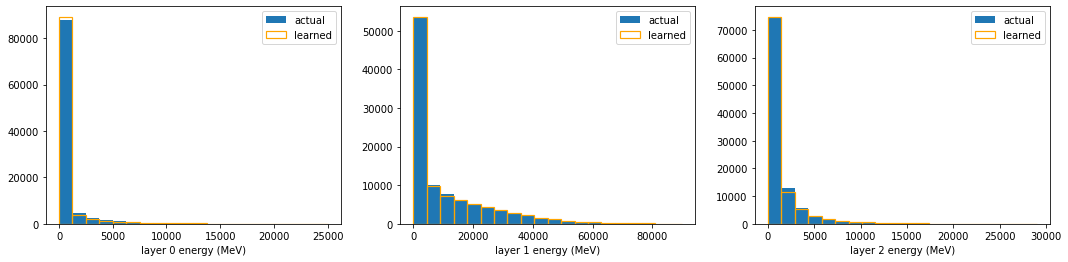

In [165]:
plot_hist_3_layers(layer0, layer1, layer2, layer0_sampled, layer1_sampled, layer2_sampled)

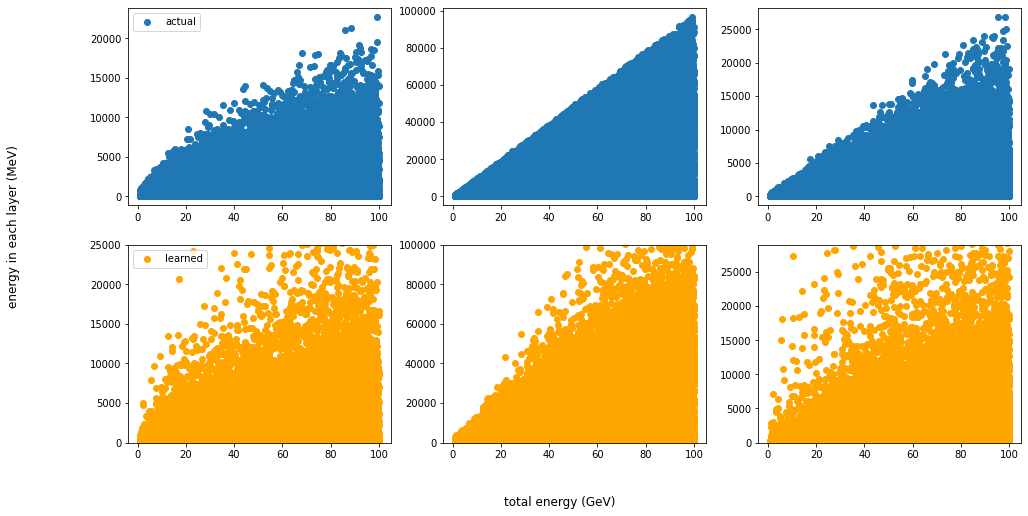

In [166]:
plot_scat_layers_v_tot(energy, layer0, layer1, layer2, \
                       layer0_sampled, layer1_sampled, layer2_sampled, \
                       25000, 100000, 29000)

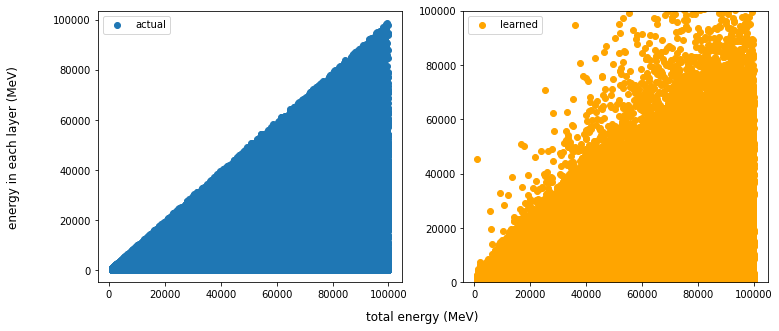

In [167]:
plot_sum_v_tot(energy, layer0, layer1, layer2, layer0_sampled, layer1_sampled, layer2_sampled)

Average energy in each layer given certain total energy

In [168]:
N_SAMPLES = 100000
energy_range = range(5, 105, 5)
avg_layer_energies = []

for e in energy_range:
    #print(energy)
    conditionals = np.full((N_SAMPLES,1), e)
    conditionals = np.log10(conditionals/10)
    samples = model.flow.sample(
        NSAMPLES,
        bijector_kwargs=make_bijector_kwargs(
            model.flow.bijector, {'bijector.': {'conditional_input': conditionals}})
    )
    samples_scaled_back = 10**samples * 10000
    avg0 = np.mean(samples_scaled_back[:,0])
    avg1 = np.mean(samples_scaled_back[:,1])
    avg2 = np.mean(samples_scaled_back[:,2])
    avg_layer_energies.append([avg0, avg1, avg2])

In [169]:
avg_energies = np.array(avg_layer_energies)
avg0_sampled = avg_energies[:,0]
avg1_sampled = avg_energies[:,1]
avg2_sampled = avg_energies[:,2]

In [170]:
all_energies = np.concatenate([energy_layer, energy], -1)
avg_layer_energies_true = []

for e in energy_range:
    selected_rows = all_energies[(all_energies[:,3] >= e-5) & (all_energies[:,3] <=e)]
    avg0 = np.mean(selected_rows[:,0])
    avg1 = np.mean(selected_rows[:,1])
    avg2 = np.mean(selected_rows[:,2])
    avg_layer_energies_true.append([avg0, avg1, avg2])

avg_energies_true = np.array(avg_layer_energies_true)
avg0_true = avg_energies_true[:,0]
avg1_true = avg_energies_true[:,1]
avg2_true = avg_energies_true[:,2]

In [171]:
def plot_avg_v_tot(avg0_true, avg1_true, avg2_true, avg0_sampled, avg1_sampled, avg2_sampled):
    fig = plt.figure(figsize=(16, 4))
    plt.subplot(131)
    plt.plot(np.linspace(5,100,20), avg0_true, label='actual')
    plt.plot(np.linspace(5,100,20), avg0_sampled, c='orange', label='learned')
    plt.legend()
    plt.subplot(132)
    plt.plot(np.linspace(5,100,20), avg1_true)
    plt.plot(np.linspace(5,100,20), avg1_sampled, c='orange')
    plt.subplot(133)
    plt.plot(np.linspace(5,100,20), avg2_true)
    plt.plot(np.linspace(5,100,20), avg2_sampled, c='orange')
    fig.supxlabel('total energy (GeV)')
    fig.supylabel('average energy in each layer (GeV)')

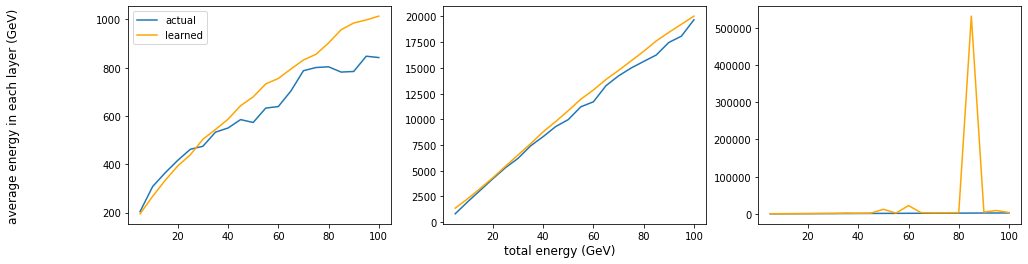

In [172]:
plot_avg_v_tot(avg0_true, avg1_true, avg2_true, avg0_sampled, avg1_sampled, avg2_sampled)

### Inference

In [26]:
import time

def scanner(model, point, N, min_range, max_range):
    start = time.time()
    points = np.array([point] * (N+1))
    zs = np.array([i/N for i in range(N+1)]).reshape((N+1,1))
    zs = zs * (max_range - min_range) + min_range
    log_probs = model.conditional_log_prob(points, zs)
    #max_prob = np.amax(log_probs)
    max_index = np.argmax(log_probs)
    c_max = max_index / N
    end = time.time()
    #print(f"Run time (s): {end-start}")
    return c_max

In [27]:
i = np.random.randint(100000)
e0, e1, e2 = layer0[i], layer1[i], layer2[i]
en = np.array([e0, e1, e2]).astype(np.float32)
en += 1e-10
en = np.log10(en/10000)

c_max = scanner(model, en, 50, -1, 1)
ans = 10 ** c_max * 10000

print(f"True particle energy: {energy[i][0]*1000} MeV")
print(f"Layer 0 energy: {layer0[i]} MeV")
print(f"Layer 1 energy: {layer1[i]} MeV")
print(f"Layer 2 energy: {layer2[i]} MeV")
print("Inferred total energy (MeV): ", ans)

True particle energy: 30875.106811523438 MeV
Layer 0 energy: 57.46918869018555 MeV
Layer 1 energy: 280.523193359375 MeV
Layer 2 energy: 29.354238510131836 MeV
Inferred total energy (MeV):  91201.08393559097


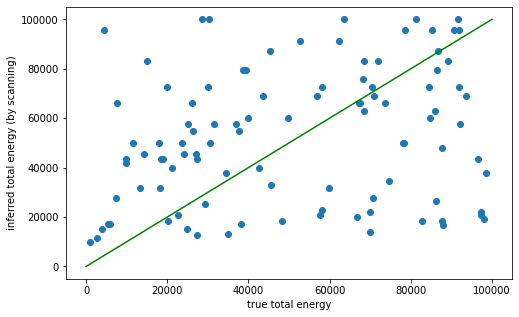

In [173]:
true_ens = []
inferred_ens = []
for j in range(100):
    i = np.random.randint(100000)
    e0, e1, e2 = layer0[i], layer1[i], layer2[i]
    en = np.array([e0, e1, e2]).astype(np.float32)
    en += 1e-10
    en = np.log10(en/10000)
    c_max = scanner(model, en, 50, -1, 1)
    ans = 10 ** c_max * 10000
    true_ens.append(energy[i][0]*1000)
    inferred_ens.append(ans)

plt.scatter(true_ens, inferred_ens)
plt.xlabel("true total energy")
plt.ylabel("inferred total energy (by scanning)")
plt.plot([0,50000,100000], [0,50000,100000], c='green')

## CaloFlow scaling

In [ ]:
n = 100000
e_tot = energy.reshape(n,)
u0 = (layer0 + layer1 + layer2)/(e_tot*1000)
u0 = np.array([min(1.0, i) for i in u0]) # make sure u0 <= 1
u1 = layer0 / (layer0 + layer1 + layer2)
u2 = layer1 / (layer1 + layer2)

In [ ]:
alpha = 1e-6
x0 = alpha + (1 - 2*alpha)*u0
x1 = alpha + (1 - 2*alpha)*u1
x2 = alpha + (1 - 2*alpha)*u2

In [ ]:
u0log = np.log(x0/(1-x0))
u1log = np.log(x1/(1-x1))
u2log = np.log(x2/(1-x2))

In [ ]:
e_tot_scaled = np.log10(e_tot/10)

In [ ]:
u_and_e_tot = np.stack([u0log, u1log, u2log, e_tot_scaled],-1)
u_and_e_tot

In [ ]:
LR = 1e-4
NUM_EPOCHS = 100
STACKED_FFJORDS = 6 #Number of stacked transformations
NUM_LAYERS = 3 #Hiddden layers per bijector
NUM_OUTPUT = 3 #Output dimension
NUM_HIDDEN = 24*NUM_OUTPUT #Hidden layer node size
NUM_COND = 1 #Number of conditional dimensions

BATCH_SIZE = 200

#Stack of bijectors 
stacked_mlps = []
for _ in range(STACKED_FFJORDS):
    mlp_model = MLP_ODE(NUM_HIDDEN, NUM_LAYERS, NUM_OUTPUT, NUM_COND)
    stacked_mlps.append(mlp_model)

callbacks=[
        EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=1e-6, verbose=1, cooldown=0)
]
    
#Create the model
model = FFJORD(stacked_mlps,BATCH_SIZE,NUM_OUTPUT,trace_type='hutchinson')
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LR))
#model.compile(optimizer=keras.optimizers.SGD(learning_rate=LR))

trainableParams = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
nonTrainableParams = np.sum([np.prod(v.get_shape()) for v in model.non_trainable_weights])
totalParams = trainableParams + nonTrainableParams
print(f"Number of trainable params: {trainableParams}")
print(f"Number of nontrainable params: {nonTrainableParams}")
print(f"Number of total params: {totalParams}")

history = model.fit(
    u_and_e_tot,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=1,
    validation_split=0.1,
    callbacks=callbacks,
)

In [ ]:
NSAMPLES = 100000

e_tot_scaled_n1 = e_tot_scaled.reshape((NSAMPLES,1))

#Sample the learned distribution
u_samples = model.flow.sample(
    NSAMPLES,
    bijector_kwargs=make_bijector_kwargs(
        model.flow.bijector, {'bijector.': {'conditional_input': e_tot_scaled_n1}})
)

In [ ]:
u_samples.shape

In [ ]:
u0log_sampled = u_samples[:,0]
u1log_sampled = u_samples[:,2]
u2log_sampled = u_samples[:,1]
x0_sampled = np.exp(u0log_sampled)/(np.exp(u0log_sampled) + 1)
x1_sampled = np.exp(u1log_sampled)/(np.exp(u1log_sampled) + 1)
x2_sampled = np.exp(u2log_sampled)/(np.exp(u2log_sampled) + 1)
alpha = 1e-6
u0_sampled = (alpha - x0_sampled)/(2*alpha - 1)
u1_sampled = (alpha - x1_sampled)/(2*alpha - 1)
u2_sampled = (alpha - x2_sampled)/(2*alpha - 1)

In [ ]:
e_tot_mev = e_tot*1000
e0_sampled = u1_sampled/u0_sampled*e_tot_mev
e1_sampled = u2_sampled*(1-u1_sampled)/u0_sampled*e_tot_mev
e2_sampled = (1-u1_sampled)*(1-u2_sampled)/u0_sampled*e_tot_mev

In [ ]:
fig = plt.figure(figsize=(18, 4))
plt.subplot(131)    
plt.hist(layer0, bins=np.linspace(0,25000,21), label='actual')
plt.hist(e0_sampled, bins=np.linspace(0,25000,21), fc=(0,0,0,0), edgecolor='orange', linewidth=1.2, label='learned')
plt.xlabel('layer 0 energy (MeV)')
plt.legend()
plt.subplot(132)    
plt.hist(layer1, bins=np.linspace(0,90000,21), label='actual')
plt.hist(e1_sampled, bins=np.linspace(0,90000,21), fc=(0,0,0,0), edgecolor='orange', linewidth=1.2, label='learned')
plt.xlabel('layer 1 energy (MeV)')
plt.legend()
plt.subplot(133)    
plt.hist(layer2, bins=np.linspace(0,29000,21), label='actual')
plt.hist(e2_sampled, bins=np.linspace(0,29000,21), fc=(0,0,0,0), edgecolor='orange', linewidth=1.2, label='learned')
plt.xlabel('layer 2 energy (MeV)')
plt.legend()

In [ ]:
e0_sampled

## Photons

In [51]:
NSAMPLES = 100000 # number of data points to load

file_path = '/global/home/users/haoxing_du/ToyFlow/gamma.hdf5'
photon_energy, photon_energy_layer, photon_energy_voxel = DataLoader(file_path, NSAMPLES)
print(photon_energy.shape, photon_energy_layer.shape, photon_energy_voxel.shape)

(100000, 1) (100000, 3) (100000, 504)


In [52]:
photon_layer0 = np.array([x[0] for x in photon_energy_layer])
photon_layer1 = np.array([x[1] for x in photon_energy_layer])
photon_layer2 = np.array([x[2] for x in photon_energy_layer])

In [53]:
# Let's look at a random data point
i = np.random.randint(1000)

print(f"True particle energy: {photon_energy[i][0]*1000} MeV")
print(f"Layer 0 energy: {photon_layer0[i]} MeV")
print(f"Layer 1 energy: {photon_layer1[i]} MeV")
print(f"Layer 2 energy: {photon_layer2[i]} MeV")
print(f"Difference (true - total): {photon_energy[i][0]*1000-photon_layer0[i]-photon_layer1[i]-photon_layer2[i]} MeV")

True particle energy: 91867.42401123047 MeV
Layer 0 energy: 1530.6787109375 MeV
Layer 1 energy: 89457.546875 MeV
Layer 2 energy: 321.7295227050781 MeV
Difference (true - total): 557.4689025878906 MeV


In [54]:
photon_all_energies = np.concatenate([photon_energy_layer, photon_energy*1000],-1)
photon_all_energies += 1e-10 # in case there are 0s and taking log of 0 is an issue
photon_energies_log = np.log10(photon_all_energies/10000)
photon_energies_log

array([[-0.24220282,  0.7948264 , -1.4598349 ,  0.8383541 ],
       [-0.03841547,  0.32464832, -2.6241615 ,  0.48409063],
       [ 0.00986106,  0.87370723, -2.0131292 ,  0.93243724],
       ...,
       [-1.1419636 ,  0.81691957, -1.4397224 ,  0.8269135 ],
       [ 0.02953856,  0.63603175, -2.339805  ,  0.7382284 ],
       [-0.3300631 , -0.12203376, -2.970138  ,  0.09038221]],
      dtype=float32)

In [142]:
LR = 4e-5
NUM_EPOCHS = 100
STACKED_FFJORDS = 5 #Number of stacked transformations
NUM_LAYERS = 3 #Hiddden layers per bijector
NUM_OUTPUT = 3 #Output dimension
NUM_HIDDEN = 12*NUM_OUTPUT #Hidden layer node size
NUM_COND = 1 #Number of conditional dimensions

BATCH_SIZE = 200

#Stack of bijectors 
stacked_mlps = []
for _ in range(STACKED_FFJORDS):
    mlp_model = MLP_ODE(NUM_HIDDEN, NUM_LAYERS, NUM_OUTPUT, NUM_COND)
    stacked_mlps.append(mlp_model)

callbacks=[
        EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=1e-6, verbose=1, cooldown=0)
]
    
#Create the model
photon_model = FFJORD(stacked_mlps,BATCH_SIZE,NUM_OUTPUT,trace_type='hutchinson')
photon_model.compile(optimizer=keras.optimizers.Adam(learning_rate=LR))
#model.compile(optimizer=keras.optimizers.SGD(learning_rate=LR))

trainableParams = np.sum([np.prod(v.get_shape()) for v in photon_model.trainable_weights])
nonTrainableParams = np.sum([np.prod(v.get_shape()) for v in photon_model.non_trainable_weights])
totalParams = trainableParams + nonTrainableParams
print(f"Number of trainable params: {trainableParams}")
print(f"Number of nontrainable params: {nonTrainableParams}")
print(f"Number of total params: {totalParams}")

photon_history = photon_model.fit(
    photon_energies_log,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=1,
    validation_split=0.1,
    callbacks=callbacks,
)

Number of trainable params: 8295
Number of nontrainable params: 2.0
Number of total params: 8297.0
Epoch 1/100
450/450 [==============================] - 132s 161ms/step - loss: 4.9023 - val_loss: 2.7555 - lr: 4.0000e-05
Epoch 2/100
450/450 [==============================] - 83s 185ms/step - loss: 0.3967 - val_loss: -0.7937 - lr: 4.0000e-05
Epoch 3/100
450/450 [==============================] - 102s 227ms/step - loss: -1.4793 - val_loss: -1.8322 - lr: 4.0000e-05
Epoch 4/100
450/450 [==============================] - 110s 245ms/step - loss: -2.2305 - val_loss: -2.4414 - lr: 4.0000e-05
Epoch 5/100
450/450 [==============================] - 116s 257ms/step - loss: -2.7013 - val_loss: -2.8976 - lr: 4.0000e-05
Epoch 6/100
450/450 [==============================] - 118s 263ms/step - loss: -3.0256 - val_loss: -3.1964 - lr: 4.0000e-05
Epoch 7/100
450/450 [==============================] - 120s 267ms/step - loss: -3.3180 - val_loss: -3.2737 - lr: 4.0000e-05
Epoch 8/100
450/450 [================

In [154]:
photon_history.history

{'loss': [4.902342796325684,
  0.39668166637420654,
  -1.4793038368225098,
  -2.230501174926758,
  -2.7013187408447266,
  -3.0256314277648926,
  -3.317978858947754,
  -3.5148866176605225,
  -3.706705093383789,
  -3.7565841674804688,
  -3.8743252754211426,
  -3.9712374210357666,
  -4.021056175231934,
  -4.1201558113098145,
  -4.103139877319336,
  -4.144368648529053,
  -4.152713775634766,
  -4.2007904052734375,
  -4.2299275398254395,
  -4.240236282348633,
  -4.231889247894287,
  -4.270185947418213,
  -4.280418872833252,
  -4.241916656494141,
  -4.268328666687012,
  -4.285306453704834,
  -4.312907695770264,
  -4.311906337738037,
  -4.347436904907227,
  -4.376814842224121,
  -4.363757610321045,
  -4.341048717498779,
  -4.389413833618164,
  -4.400911808013916,
  -4.387057304382324,
  -4.404107570648193,
  -4.3677520751953125,
  -4.411582946777344,
  -4.383821964263916,
  -4.402571201324463,
  -4.376292705535889,
  -4.390871524810791,
  -4.374131679534912,
  -4.387184143066406,
  -4.40360593

In [155]:
min(photon_history.history['val_loss'])

-4.473727226257324

In [143]:
NSAMPLES = 100000

photon_energy_scaled = photon_energies_log[:,-1].reshape((NSAMPLES,1))

#Sample the learned distribution
photon_samples_with_energy = photon_model.flow.sample(
    NSAMPLES,
    bijector_kwargs=make_bijector_kwargs(
        photon_model.flow.bijector, {'bijector.': {'conditional_input': photon_energy_scaled}})
)

In [144]:
photon_samples_scaled = np.concatenate([photon_samples_with_energy, photon_energy_scaled],-1)
#transformed_scaled_back = scaler.inverse_transform(transformed_scaled)
photon_samples_expd = 10**photon_samples_scaled * 10000
photon_layer0_sampled = photon_samples_expd[:,0]
photon_layer1_sampled = photon_samples_expd[:,1]
photon_layer2_sampled = photon_samples_expd[:,2]

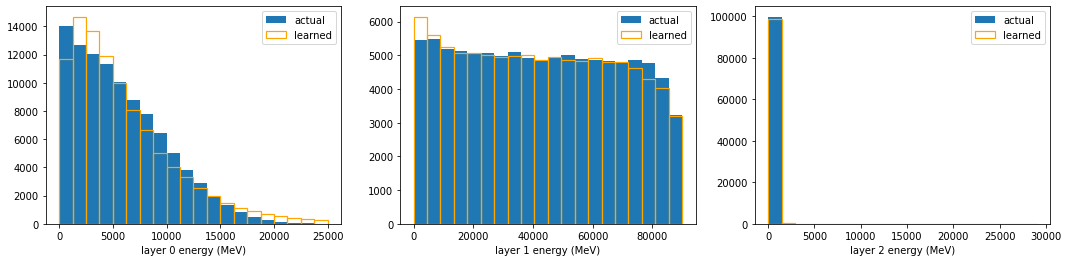

In [145]:
plot_hist_3_layers(photon_layer0, photon_layer1, photon_layer2, \
                   photon_layer0_sampled, photon_layer1_sampled, photon_layer2_sampled)

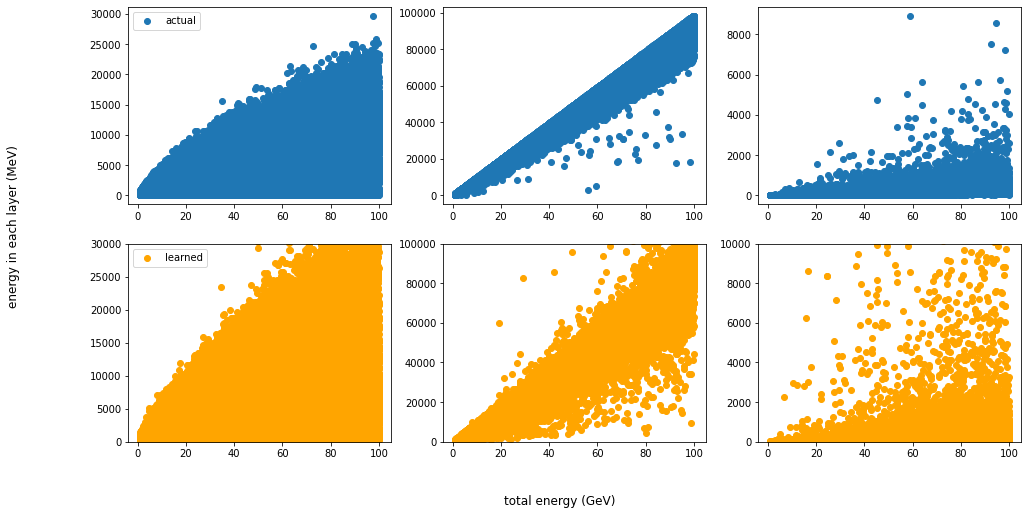

In [146]:
plot_scat_layers_v_tot(photon_energy, photon_layer0, photon_layer1, photon_layer2, \
                       photon_layer0_sampled, photon_layer1_sampled, photon_layer2_sampled, \
                       30000, 100000, 10000)

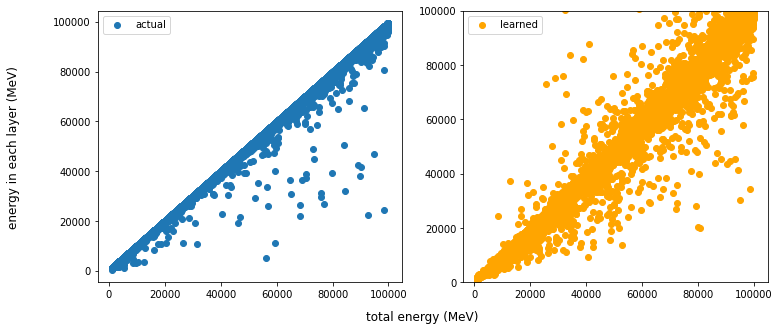

In [147]:
plot_sum_v_tot(photon_energy, photon_layer0, photon_layer1, photon_layer2, \
                       photon_layer0_sampled, photon_layer1_sampled, photon_layer2_sampled)

In [148]:
N_SAMPLES = 100000
energy_range = range(5, 105, 5)
photon_avg_layer_energies = []

for e in energy_range:
    #print(energy)
    conditionals = np.full((N_SAMPLES,1), e)
    conditionals = np.log10(conditionals/10)
    photon_samples = photon_model.flow.sample(
        NSAMPLES,
        bijector_kwargs=make_bijector_kwargs(
            photon_model.flow.bijector, {'bijector.': {'conditional_input': conditionals}})
    )
    photon_samples_scaled_back = 10**photon_samples * 10000
    avg0 = np.mean(photon_samples_scaled_back[:,0])
    avg1 = np.mean(photon_samples_scaled_back[:,1])
    avg2 = np.mean(photon_samples_scaled_back[:,2])
    photon_avg_layer_energies.append([avg0, avg1, avg2])

In [149]:
photon_avg_energies = np.array(photon_avg_layer_energies)
photon_avg0_sampled = photon_avg_energies[:,0]
photon_avg1_sampled = photon_avg_energies[:,1]
photon_avg2_sampled = photon_avg_energies[:,2]

In [150]:
photon_all_energies = np.concatenate([photon_energy_layer, photon_energy], -1)
photon_avg_layer_energies_true = []

for e in energy_range:
    selected_rows = photon_all_energies[(photon_all_energies[:,3] >= e-5) & (photon_all_energies[:,3] <=e)]
    avg0 = np.mean(selected_rows[:,0])
    avg1 = np.mean(selected_rows[:,1])
    avg2 = np.mean(selected_rows[:,2])
    photon_avg_layer_energies_true.append([avg0, avg1, avg2])

photon_avg_energies_true = np.array(photon_avg_layer_energies_true)
photon_avg0_true = photon_avg_energies_true[:,0]
photon_avg1_true = photon_avg_energies_true[:,1]
photon_avg2_true = photon_avg_energies_true[:,2]

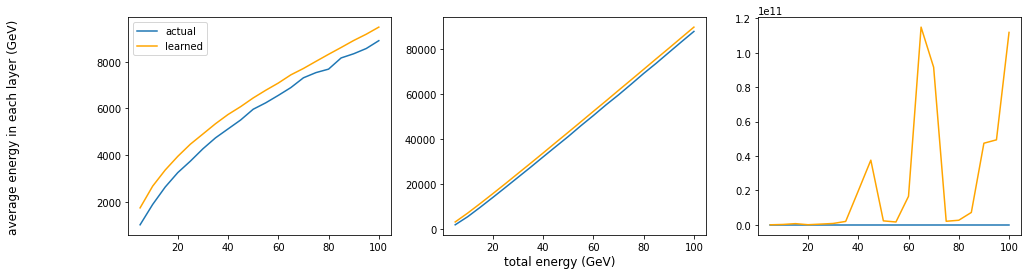

In [151]:
plot_avg_v_tot(photon_avg0_true, photon_avg1_true, photon_avg2_true, \
               photon_avg0_sampled, photon_avg1_sampled, photon_avg2_sampled)

In [152]:
i = np.random.randint(100000)
e0, e1, e2 = photon_layer0[i], photon_layer1[i], photon_layer2[i]
en = np.array([e0, e1, e2]).astype(np.float32)
en += 1e-10
en = np.log10(en/10000)

c_max = scanner(photon_model, en, 50, -1, 1)
ans = 10 ** c_max * 10000

print(f"True particle energy: {photon_energy[i][0]*1000} MeV")
print(f"Layer 0 energy: {photon_layer0[i]} MeV")
print(f"Layer 1 energy: {photon_layer1[i]} MeV")
print(f"Layer 2 energy: {photon_layer2[i]} MeV")
print("Inferred total energy (MeV): ", ans)

True particle energy: 32939.77737426758 MeV
Layer 0 energy: 5849.720703125 MeV
Layer 1 energy: 26339.75390625 MeV
Layer 2 energy: 12.562888145446777 MeV
Inferred total energy (MeV):  57543.993733715695


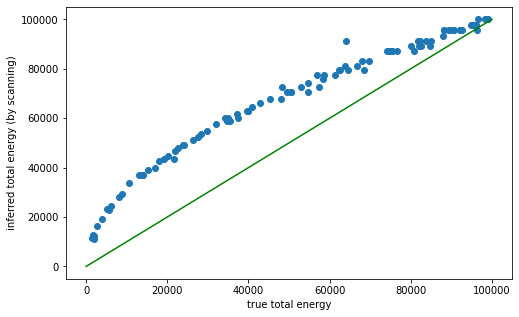

In [153]:
photon_true_ens = []
photon_inferred_ens = []
for j in range(100):
    i = np.random.randint(100000)
    e0, e1, e2 = photon_layer0[i], photon_layer1[i], photon_layer2[i]
    en = np.array([e0, e1, e2]).astype(np.float32)
    en += 1e-10
    en = np.log10(en/10000)
    c_max = scanner(photon_model, en, 100, -1, 1)
    ans = 10 ** c_max * 10000
    photon_true_ens.append(photon_energy[i][0]*1000)
    photon_inferred_ens.append(ans)

plt.scatter(photon_true_ens, photon_inferred_ens)
plt.xlabel("true total energy")
plt.ylabel("inferred total energy (by scanning)")
plt.plot([0,50000,100000], [0,50000,100000], c='green')